# Testing the embedding processsing methods
find_similar_qdrant, find_representative, leverage_OOD, find_mismatches

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

from luxonis_ml.embeddings.methods.duplicate import find_similar
from luxonis_ml.embeddings.methods.mistakes import find_mismatches_centroids
from luxonis_ml.embeddings.methods.OOD import leverage_OOD
from luxonis_ml.embeddings.methods.representative import (
    calculate_similarity_matrix,
    find_representative_kmedoids,
)
from luxonis_ml.embeddings.utils.qdrant import Distance, QdrantAPI, QdrantManager
from luxonis_ml.embeddings.utils.weaviate import WeaviateAPI

/home/paperspace/Luxonis/lux-ml/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Embedding processing methods for the QDRANT search engine

In [11]:
# Start Qdrant docker container
QdrantManager("qdrant/qdrant", "qdrant_container2").start_docker_qdrant()

# Connect to Qdrant
qdrant_api = QdrantAPI("localhost", 6333, "mnist4")

# Create a collection
qdrant_api.create_collection(vector_size=2048, distance="cosine")

Container is already running.
Collection already exists


### Find representative images

In [14]:
ids, embeddings = qdrant_api.retrieve_all_embeddings()

In [15]:
similarity_matrix = calculate_similarity_matrix(embeddings)

In [16]:
desired_size = int(len(embeddings) * 0.05)
# desired_size = 10
selected_image_indices = find_representative_kmedoids(similarity_matrix, desired_size)
# selected_image_indices = find_representative_greedy_qdrant(qdrant_client, desired_size, 0, "mnist3")

In [17]:
ids_sel = np.array(ids)[selected_image_indices].tolist()
payloads = qdrant_api.get_payloads_from_ids(ids_sel)

/home/paperspace/Luxonis/lux-ml/lib/python3.9/site-packages/httpx/_content.py:204: DeprecationWarning: Use 'content=<...>' to upload raw bytes/text content.
  warnings.warn(message, DeprecationWarning)


In [18]:
represent_imgs = [p["image_path"] for p in payloads]
len(represent_imgs)

318

In [ ]:
# set plt size
plt.rcParams["figure.figsize"] = [30, 10]

for j in range(min(10, len(represent_imgs))):
    plt.subplot(1, 10, j + 1)
    img = cv2.imread(represent_imgs[j])
    plt.imshow(img)

plt.show()

### Out-of-distribution detection

In [ ]:
idx = leverage_OOD(np.array(embeddings))

In [ ]:
ids_sel = np.array(ids)[idx].tolist()
payloads = qdrant_api.get_payloads_from_ids(ids_sel)

In [ ]:
outlier_imgs = [p["image_path"] for p in payloads]

In [ ]:
plt.rcParams["figure.figsize"] = [30, 10]

for j in range(min(10, len(outlier_imgs))):
    plt.subplot(1, 10, j + 1)
    img = cv2.imread(outlier_imgs[j])
    plt.imshow(img)

plt.show()

### Find similar images

In [ ]:
i_sim, path_sim = find_similar(
    ids[4],
    "qdrant",
    qdrant_api,
    dataset="",
    k=100,
    n=100,
    method="first",
    k_method="kde_peaks",
    kde_bw="scott",
    plot=True,
)

In [ ]:
plt.rcParams["figure.figsize"] = [30, 10]

for j in range(min(10, len(path_sim))):
    plt.subplot(1, 10, j + 1)
    img = cv2.imread(path_sim[j])
    plt.imshow(img)

plt.show()

### Find mismatches

In [ ]:
ids, embeddings = qdrant_api.get_all_embeddings()
payloads = qdrant_api.get_payloads_from_ids(ids)

In [ ]:
X = np.array(embeddings)
y = np.array([p["class"] for p in payloads])

In [ ]:
mis_ix, new_y = find_mismatches_centroids(X, y)

In [ ]:
# find img paths for misclassified images
mis_img_paths = [payloads[i]["image_path"] for i in mis_ix]

In [ ]:
# plot
plt.rcParams["figure.figsize"] = [30, 10]

for j in range(min(5, len(mis_img_paths))):
    plt.subplot(1, 10, j + 1)
    img = cv2.imread(mis_img_paths[j])
    plt.title(f"True: {y[mis_ix[j]]}, Pred: {new_y[j]}")
    plt.imshow(img)

plt.show()

## Embedding processing methods using Weaviate

In [2]:
w_api = WeaviateAPI("http://localhost:8080")
w_api.create_collection(collection_name="Mnist_LDF")

In [3]:
embeddings, ids = w_api.get_all_embeddings_and_ids()
labels = w_api.get_labels(ids)

In [4]:
X = np.array(embeddings)
y = np.array(labels)

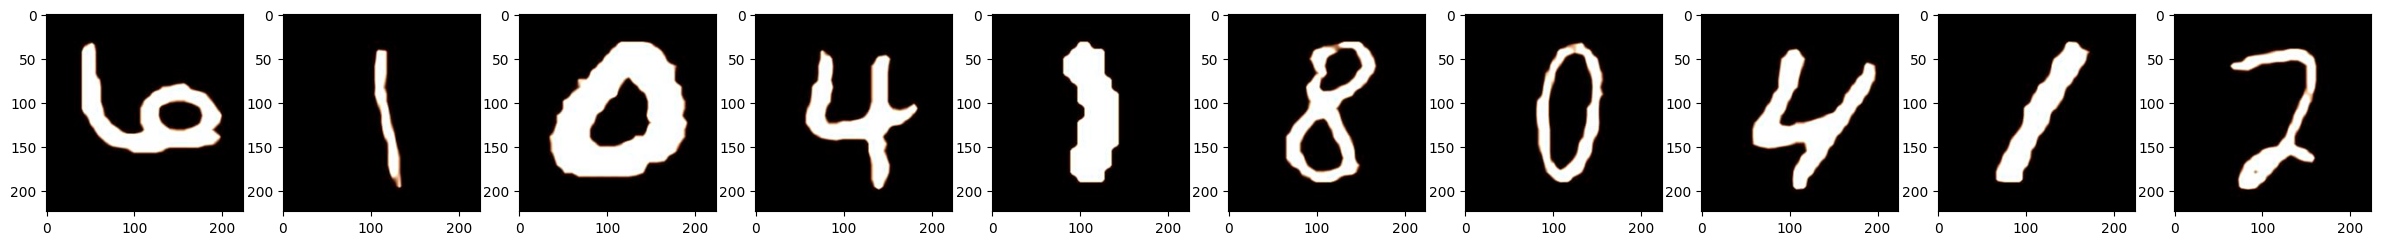

In [5]:
# find representative images
desired_size = int(len(embeddings) * 0.05)
similarity_matrix = calculate_similarity_matrix(embeddings)
selected_image_indices = find_representative_kmedoids(similarity_matrix, desired_size)

# find img paths for representative images
represent_img_paths = [ids[i] for i in selected_image_indices]

# plot
plt.rcParams["figure.figsize"] = [30, 10]

for j in range(min(10, len(represent_img_paths))):
    plt.subplot(1, 10, j + 1)
    uuid = str(represent_img_paths[j])
    img_filepath = "./mnist_images/" + uuid + ".jpg"
    img = cv2.imread(img_filepath)
    plt.imshow(img)

plt.show()

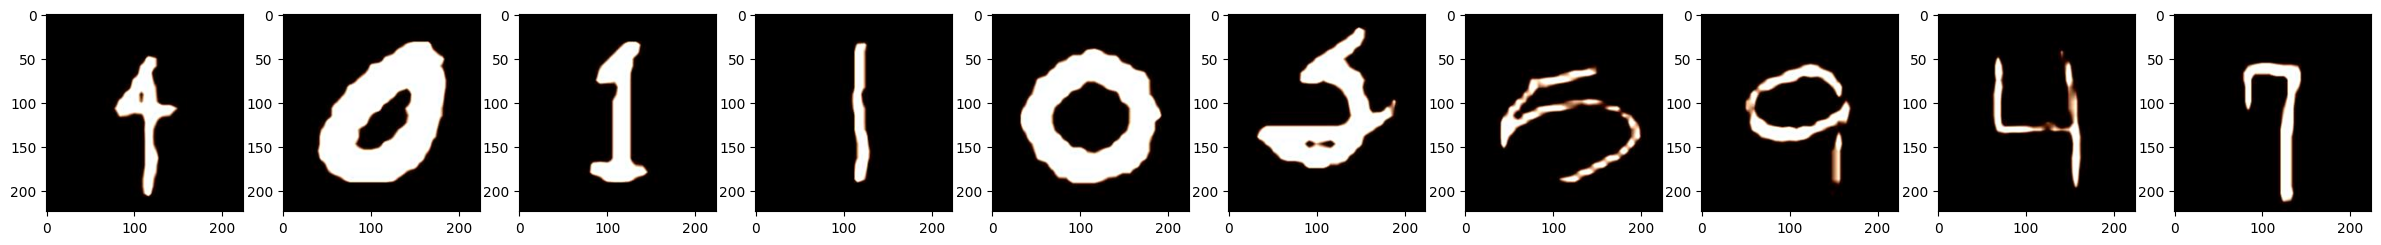

In [6]:
# find outlier images
idx = leverage_OOD(X)

# find img paths for outlier images
outlier_img_paths = [ids[i] for i in idx]

# plot
plt.rcParams["figure.figsize"] = [30, 10]

for j in range(min(10, len(outlier_img_paths))):
    plt.subplot(1, 10, j + 1)
    uuid = str(outlier_img_paths[j])
    img_filepath = "./mnist_images/" + uuid + ".jpg"
    img = cv2.imread(img_filepath)
    plt.imshow(img)

plt.show()

/home/paperspace/Luxonis/lux-ml/lib/python3.9/site-packages/scipy/optimize/_zeros_py.py:799: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  r = _zeros._brentq(f, a, b, xtol, rtol, maxiter, args, full_output, disp)


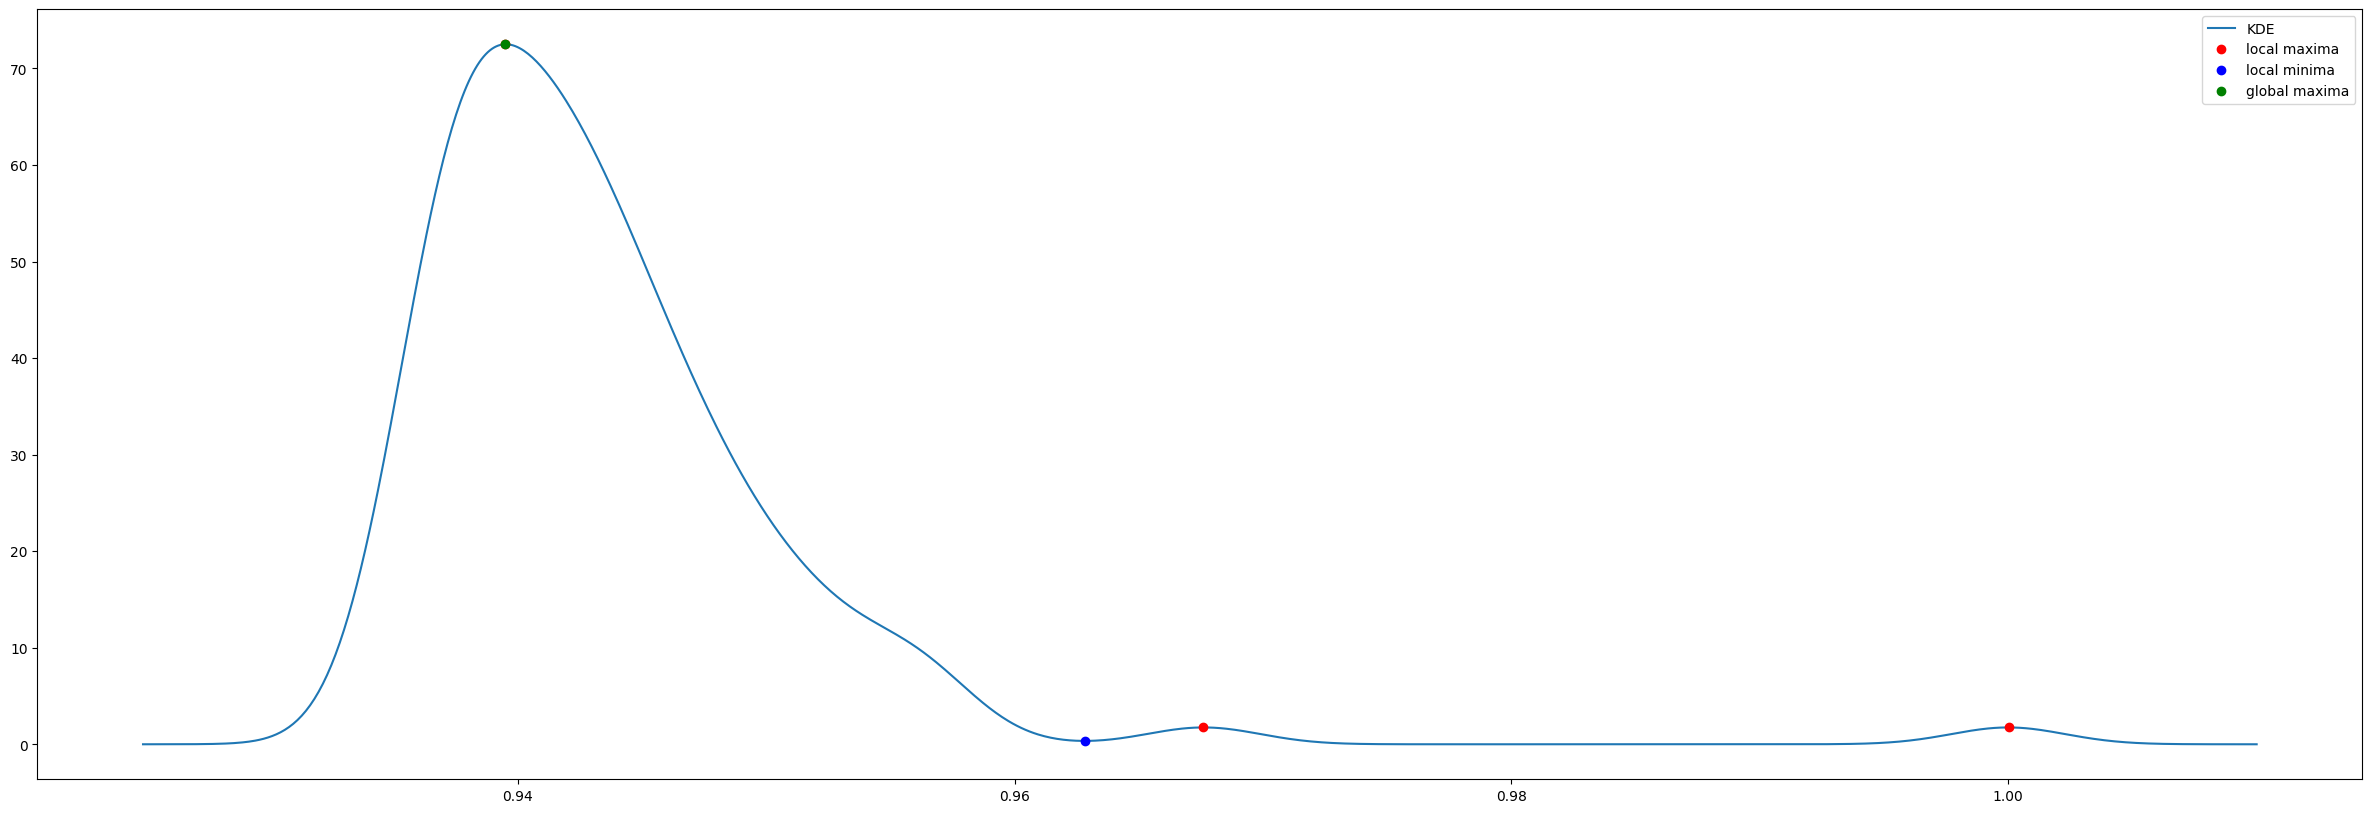

2 0.9628176993770046


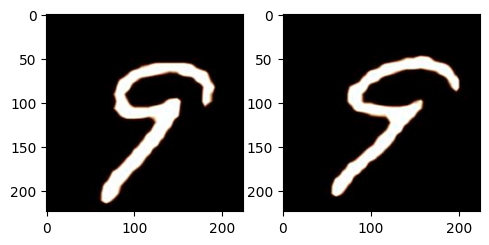

In [7]:
ids_str = [str(i) for i in ids]

# find similar/duplicate images
i_sim = find_similar(
    ids_str[4],
    "weaviate",
    w_api,
    dataset="",
    k=100,
    n=100,
    method="first",
    k_method="kde_peaks",
    kde_bw="scott",
    plot=True,
)

# find img paths for similar images
sim_img_paths = i_sim

# plot
plt.rcParams["figure.figsize"] = [30, 10]

for j in range(min(10, len(sim_img_paths))):
    plt.subplot(1, 10, j + 1)
    uuid = str(sim_img_paths[j])
    img_filepath = "./mnist_images/" + uuid + ".jpg"
    img = cv2.imread(img_filepath)
    plt.imshow(img)

plt.show()

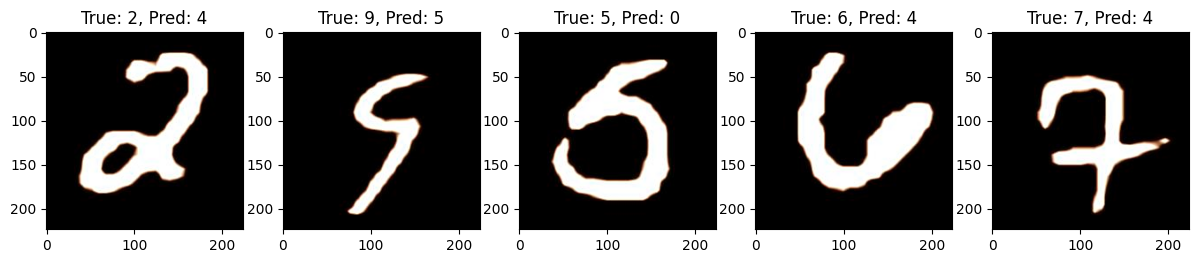

In [9]:
# find misclassified images
mis_ix, new_y = find_mismatches_centroids(X, y)

# find img paths for misclassified images
mis_img_paths = [ids[i] for i in mis_ix]

# plot
plt.rcParams["figure.figsize"] = [30, 10]

for j in range(min(5, len(mis_img_paths))):
    plt.subplot(1, 10, j + 1)
    uuid = str(mis_img_paths[j])
    img_filepath = "./mnist_images/" + uuid + ".jpg"
    img = cv2.imread(img_filepath)
    plt.title(f"True: {y[mis_ix[j]]}, Pred: {new_y[j]}")
    plt.imshow(img)

plt.show()

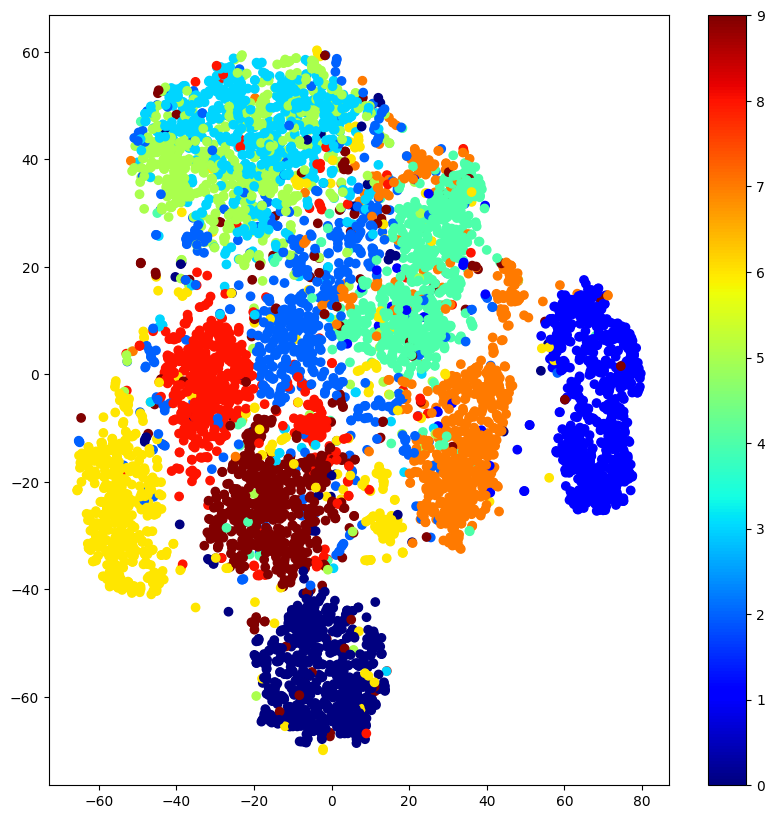

In [10]:
# plot t-sne
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(X)

plt.rcParams["figure.figsize"] = [10, 10]
y_color = [int(i) for i in y]
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_color, cmap="jet")
plt.colorbar()
plt.show()